In [3]:
import requests
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Data Fetching

In [ ]:
# function for getting the names of all the pokemon in a generation (int)
def get_gen_pokemon(generation):
    response = requests.get(f"https://pokeapi.co/api/v2/generation/{generation}")
    data = response.json()
    # sort the data by their pokemon ids using the ending part of their urls
    data["pokemon_species"].sort(key=lambda x: int(x["url"]
                                 .replace("https://pokeapi.co/api/v2/pokemon-species/", "")
                                 .replace("/", "")))                            
    return data["pokemon_species"]

In [ ]:
# function for generating a pokemon model 
def generate_pokemon_model(generation, name, id, pokemon_data):
    pokemon_model = {}
    pokemon_model["name"] = name
    pokemon_model["id"] = id
    pokemon_model["generation"] = generation
    pokemon_model["types"] = []
    for type in pokemon_data["types"]:
        pokemon_model["types"].append(type["type"]["name"])
    return pokemon_model

In [ ]:
# create an empty list to store all the pokemon
pokemon_list = []

# looks like some pokemon will have broken urls, we'll save those here
# so we can let the maintainers of pokeapi know that these routes are broken
broken_endpoints = []

In [ ]:
# now we need a function that can fetch all the generational data and use that to grab all the detailed
# pokemon data within that generation. Along the way, when we encounter a broken
# url, we'll note that and use a fallback endpoint to get that pokemon's dat
def get_all_pokemon_data(gen_num):
    generation = get_gen_pokemon(gen_num)

    # loop through each pokemon in the generation
    for pokemon in generation:
        # get the pokemon's name
        name = pokemon["name"]
        url = f"https://pokeapi.co/api/v2/pokemon/{name}"
        # get the url for the pokemon's data
        response = requests.get(url)
        try:
            pokemon_data = response.json()
        except requests.exceptions.JSONDecodeError as e:
            pokemon_id = pokemon["url"].replace("https://pokeapi.co/api/v2/pokemon-species/", "").replace("/", "")            
            fallback_url = f"https://pokeapi.co/api/v2/pokemon/{pokemon_id}"
            response = requests.get(fallback_url)        
            pokemon_data = response.json()
            broken_endpoints.append(
                {
                    "name": name,
                    "generation": gen_num,
                    "broken_url": url,
                    "fallback_url": fallback_url,                    
                }
            )
        finally:
            pokemon_id_number = pokemon_data["id"]
            pokemon_model = generate_pokemon_model(gen_num, name, pokemon_id_number, pokemon_data) 
            pokemon_list.append(pokemon_model)
    print(f"Done fetching all {len(generation)} pokemon data for Generation {gen_num}")    

In [ ]:
# now we can combine all the functions together to get all the 
# pokemon data for every generation
for gen_num in range(1,10):
    get_all_pokemon_data(gen_num)

In [ ]:
# view pokemon_list to make sure it has all 1017 pokemon
print(len(pokemon_list))
pokemon_list_df = pd.DataFrame.from_dict(pokemon_list)
print(pokemon_list_df.to_markdown())

In [ ]:
# let's view how many broken routes we found
print(len(broken_endpoints))
broken_endpoints_df = pd.DataFrame.from_dict(broken_endpoints)
print(broken_endpoints_df.to_markdown())

In [ ]:
# save the pokemon_list and broken_routes as json files
with open(f"./data/pokemon_list.json", "w") as f:
    json.dump(pokemon_list, f, indent=4)

with open(f"./data/broken_endpoints.json", "w") as f:
    json.dump(broken_endpoints, f, indent=4)    

# Data Clean-Up

In [4]:
# let's open our pokemon_list.json and turn it into a pandas dataframe
with open('./data/pokemon_list.json', 'r') as f:
        all_pokemon_dict = json.load(f)
all_pokemon_df = pd.read_json('./data/pokemon_list.json')
all_pokemon_df

,name,id,generation,types
0,bulbasaur,1,1,"[grass, poison]"
1,ivysaur,2,1,"[grass, poison]"
2,venusaur,3,1,"[grass, poison]"
3,charmander,4,1,[fire]
4,charmeleon,5,1,[fire]
...,...,...,...,...
1012,sinistcha,1013,9,"[grass, ghost]"
1013,okidogi,1014,9,"[poison, fighting]"
1014,munkidori,1015,9,"[poison, psychic]"
1015,fezandipiti,1016,9,"[poison, fairy]"


In [5]:
# looking at our column types, we can see that the data in the "types" column
# is an object representing an array of types (since some pokemon only have one type,
# while others have two types) 
all_pokemon_df.dtypes

name          object
id             int64
generation     int64
types         object
dtype: object

In [6]:
# having a array as a column isn't ideal for the type of analysis we want to do later
# so let's try to normalize the types data from an array into 'type 1' and 'type 2'
# we'll build a function that can help us
def normalize_pokemon_model(pokemon):
    name = pokemon['name']
    id = pokemon['id']
    generation = pokemon['generation']
    type1 = pokemon['types'][0]
    type2 = ""
    if len(pokemon['types']) > 1:
        type2 = pokemon['types'][1]
    model = { 
        'name': name, 
        'id': id, 
        'generation': generation, 
        'type1': type1, 
        'type2': type2
    }
    return model

In [7]:
# now let's use our function with our original json dict to normalize the types
# using list comprehension, this can be accomplished in 1 line!
normalized = [normalize_pokemon_model(pokemon) for pokemon in all_pokemon_dict]

In [8]:
all_pokemon_df = pd.DataFrame.from_dict(normalized)
# now our dataframe should have "type1" & "type2" columns instead of the "types" column
all_pokemon_df

,name,id,generation,type1,type2
0,bulbasaur,1,1,grass,poison
1,ivysaur,2,1,grass,poison
2,venusaur,3,1,grass,poison
3,charmander,4,1,fire,
4,charmeleon,5,1,fire,
...,...,...,...,...,...
1012,sinistcha,1013,9,grass,ghost
1013,okidogi,1014,9,poison,fighting
1014,munkidori,1015,9,poison,psychic
1015,fezandipiti,1016,9,poison,fairy


In [9]:
# let's also turn our broken_endpoints json into a dataframe
broken_endpoints_df = pd.read_json('./data/broken_endpoints.json')
broken_endpoints_df

,name,generation,broken_url,fallback_url
0,deoxys,3,https://pokeapi.co/api/v2/pokemon/deoxys,https://pokeapi.co/api/v2/pokemon/386
1,wormadam,4,https://pokeapi.co/api/v2/pokemon/wormadam,https://pokeapi.co/api/v2/pokemon/413
2,giratina,4,https://pokeapi.co/api/v2/pokemon/giratina,https://pokeapi.co/api/v2/pokemon/487
3,shaymin,4,https://pokeapi.co/api/v2/pokemon/shaymin,https://pokeapi.co/api/v2/pokemon/492
4,basculin,5,https://pokeapi.co/api/v2/pokemon/basculin,https://pokeapi.co/api/v2/pokemon/550
5,darmanitan,5,https://pokeapi.co/api/v2/pokemon/darmanitan,https://pokeapi.co/api/v2/pokemon/555
6,tornadus,5,https://pokeapi.co/api/v2/pokemon/tornadus,https://pokeapi.co/api/v2/pokemon/641
7,thundurus,5,https://pokeapi.co/api/v2/pokemon/thundurus,https://pokeapi.co/api/v2/pokemon/642
8,landorus,5,https://pokeapi.co/api/v2/pokemon/landorus,https://pokeapi.co/api/v2/pokemon/645
9,keldeo,5,https://pokeapi.co/api/v2/pokemon/keldeo,https://pokeapi.co/api/v2/pokemon/647


In [10]:
# we eventually want to combine the broken_endpoints data to the all_pokemon data
# but first we'll need to clean up the broken_endpoints table 
broken_endpoints_df_cleaned = broken_endpoints_df.drop(
    ['generation', 'broken_url'], axis=1
)
broken_endpoints_df_cleaned

,name,fallback_url
0,deoxys,https://pokeapi.co/api/v2/pokemon/386
1,wormadam,https://pokeapi.co/api/v2/pokemon/413
2,giratina,https://pokeapi.co/api/v2/pokemon/487
3,shaymin,https://pokeapi.co/api/v2/pokemon/492
4,basculin,https://pokeapi.co/api/v2/pokemon/550
5,darmanitan,https://pokeapi.co/api/v2/pokemon/555
6,tornadus,https://pokeapi.co/api/v2/pokemon/641
7,thundurus,https://pokeapi.co/api/v2/pokemon/642
8,landorus,https://pokeapi.co/api/v2/pokemon/645
9,keldeo,https://pokeapi.co/api/v2/pokemon/647


In [11]:
# now we can merge the two dataframes together using the pokemon name
merged_all_pokemon = all_pokemon_df.merge(broken_endpoints_df_cleaned, how="left", on="name")
merged_all_pokemon

,name,id,generation,type1,type2,fallback_url
0,bulbasaur,1,1,grass,poison,NaN
1,ivysaur,2,1,grass,poison,NaN
2,venusaur,3,1,grass,poison,NaN
3,charmander,4,1,fire,,NaN
4,charmeleon,5,1,fire,,NaN
...,...,...,...,...,...,...
1012,sinistcha,1013,9,grass,ghost,NaN
1013,okidogi,1014,9,poison,fighting,NaN
1014,munkidori,1015,9,poison,psychic,NaN
1015,fezandipiti,1016,9,poison,fairy,NaN


In [12]:
# we can check that the broken links data merged correctly by ensuring 
# validating that there are 28 non-NaN records in the dataframe
len(merged_all_pokemon.dropna())

28

In [13]:
# now we should correct all the NaN urls 
for index, pokemon in merged_all_pokemon.iterrows():
    if pd.isnull(pokemon['fallback_url']):
        merged_all_pokemon.loc[index, 'fallback_url'] = f"https://pokeapi.co/api/v2/pokemon/{pokemon['name']}"
merged_all_pokemon
        

,name,id,generation,type1,type2,fallback_url
0,bulbasaur,1,1,grass,poison,https://pokeapi.co/api/v2/pokemon/bulbasaur
1,ivysaur,2,1,grass,poison,https://pokeapi.co/api/v2/pokemon/ivysaur
2,venusaur,3,1,grass,poison,https://pokeapi.co/api/v2/pokemon/venusaur
3,charmander,4,1,fire,,https://pokeapi.co/api/v2/pokemon/charmander
4,charmeleon,5,1,fire,,https://pokeapi.co/api/v2/pokemon/charmeleon
...,...,...,...,...,...,...
1012,sinistcha,1013,9,grass,ghost,https://pokeapi.co/api/v2/pokemon/sinistcha
1013,okidogi,1014,9,poison,fighting,https://pokeapi.co/api/v2/pokemon/okidogi
1014,munkidori,1015,9,poison,psychic,https://pokeapi.co/api/v2/pokemon/munkidori
1015,fezandipiti,1016,9,poison,fairy,https://pokeapi.co/api/v2/pokemon/fezandipiti


In [14]:
# finally, let's correct the "fallback_url" column label since the column now displays the correct urls for all
merged_all_pokemon.rename(columns={'fallback_url':'url'}, inplace=True)
merged_all_pokemon

,name,id,generation,type1,type2,url
0,bulbasaur,1,1,grass,poison,https://pokeapi.co/api/v2/pokemon/bulbasaur
1,ivysaur,2,1,grass,poison,https://pokeapi.co/api/v2/pokemon/ivysaur
2,venusaur,3,1,grass,poison,https://pokeapi.co/api/v2/pokemon/venusaur
3,charmander,4,1,fire,,https://pokeapi.co/api/v2/pokemon/charmander
4,charmeleon,5,1,fire,,https://pokeapi.co/api/v2/pokemon/charmeleon
...,...,...,...,...,...,...
1012,sinistcha,1013,9,grass,ghost,https://pokeapi.co/api/v2/pokemon/sinistcha
1013,okidogi,1014,9,poison,fighting,https://pokeapi.co/api/v2/pokemon/okidogi
1014,munkidori,1015,9,poison,psychic,https://pokeapi.co/api/v2/pokemon/munkidori
1015,fezandipiti,1016,9,poison,fairy,https://pokeapi.co/api/v2/pokemon/fezandipiti


# Data Analysis

In [15]:
# Now let's analyze the number of monotypes and dualtypes in each generation
def analyze_monotypes(gen_num):
    df = merged_all_pokemon[merged_all_pokemon['generation'] == gen_num]
    monotypes = len(df[df['type2'] == ""])
    dualtypes = len(df[df['type2'] != ""])
    return {
        "generation": gen_num,
        "monotypes": monotypes,
        "dualtypes": dualtypes
    }

gen_types = []

for gen_num in range(1,10):
    result = analyze_monotypes(gen_num)
    gen_types.append(result)

gen_types_df = pd.DataFrame.from_dict(gen_types)
gen_types_df

,generation,monotypes,dualtypes
0,1,84,67
1,2,51,49
2,3,69,66
3,4,54,53
4,5,82,74
5,6,31,41
6,7,33,55
7,8,52,44
8,9,42,70


Text(0.5, 1.0, 'Mono vs Dual Types by Generation')

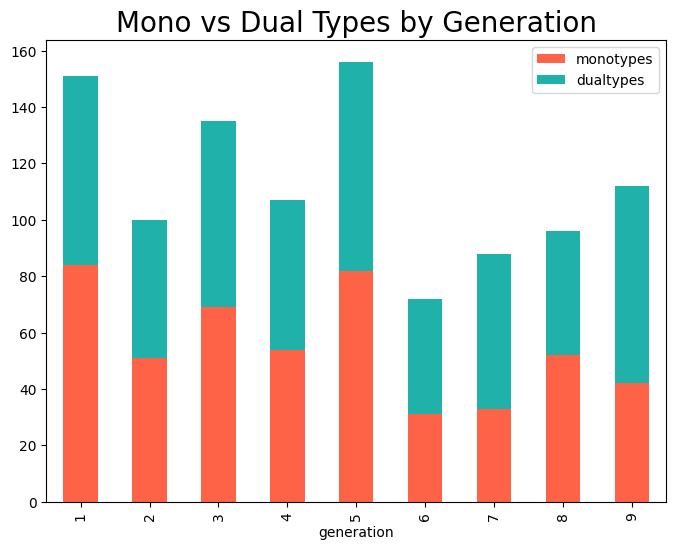

In [16]:
ax = gen_types_df.plot.bar(
    x='generation',
    stacked=True,
    color=['tomato','lightseagreen'], 
    figsize=(8,6)
)
ax.set_title('Mono vs Dual Types by Generation', fontsize=20)

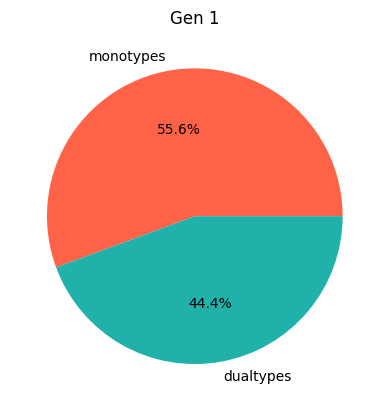

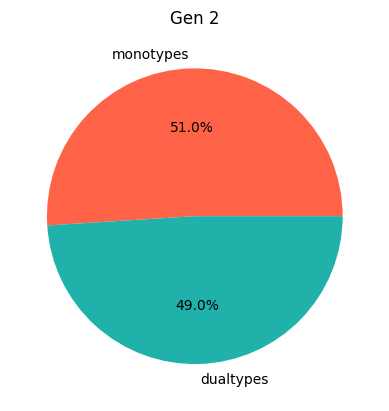

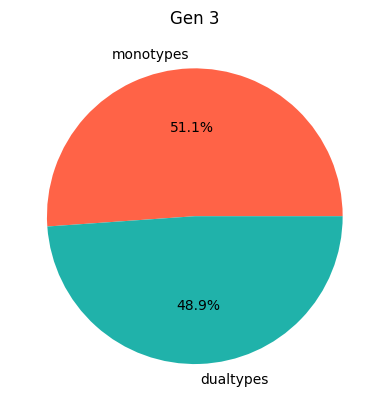

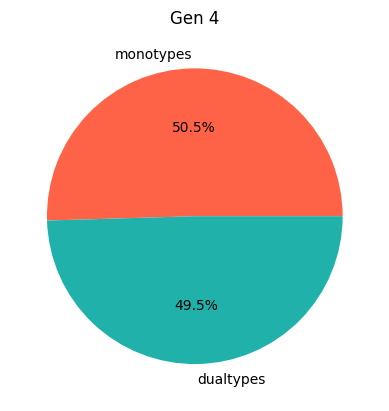

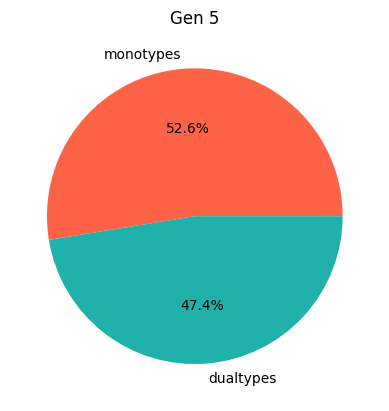

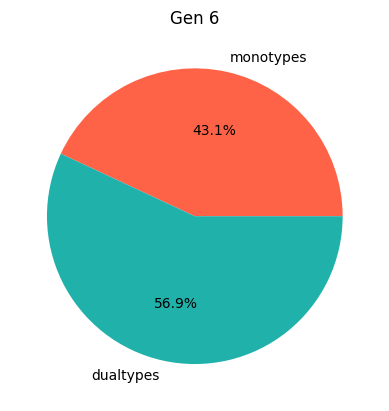

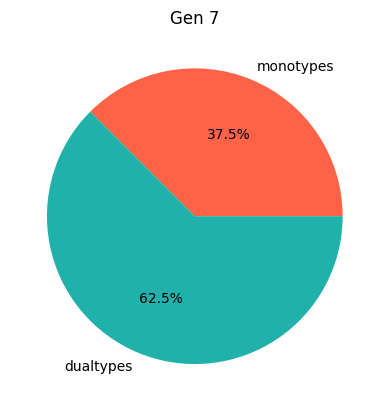

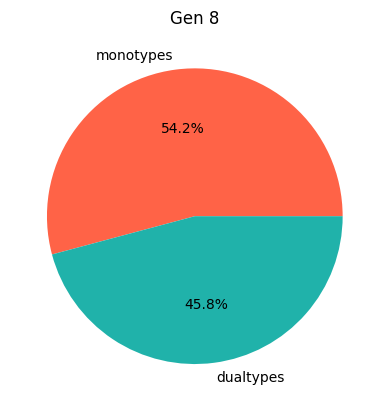

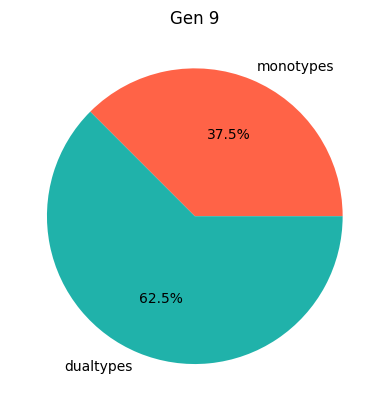

In [17]:
def create_pie_chart(gen_num):
    index = gen_num - 1
    mono = gen_types_df.loc[index]['monotypes']
    dual = gen_types_df.loc[index]['dualtypes']

    y = np.array([mono, dual])
    mylabels = ["monotypes", "dualtypes"]

    plt.pie(y, labels = mylabels, autopct='%1.1f%%', colors=['tomato','lightseagreen'])
    plt.title(f"Gen {gen_num}")
    plt.show()


for gen_num in range(1,10):
    create_pie_chart(gen_num)

plt.show()


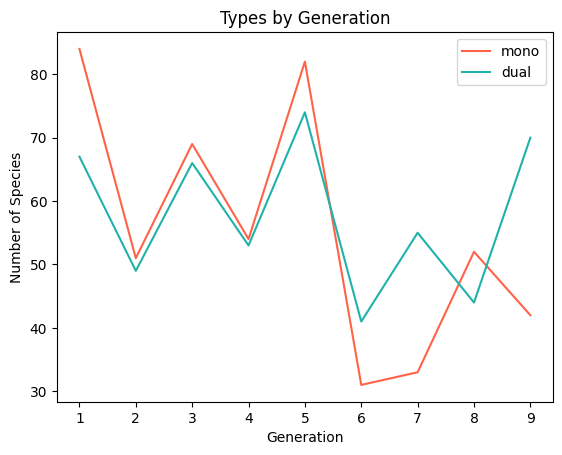

In [18]:
x = np.array(gen_types_df['generation'].to_list())
monotypes_values = np.array(gen_types_df['monotypes'].to_list())
dualtypes_values = np.array(gen_types_df['dualtypes'].to_list())
plt.plot(x, monotypes_values, 'tomato', label='mono')
plt.plot(x, dualtypes_values, 'lightseagreen', label='dual')

plt.xlabel('Generation')
plt.ylabel('Number of Species')
plt.legend()
plt.title('Types by Generation')

plt.show()

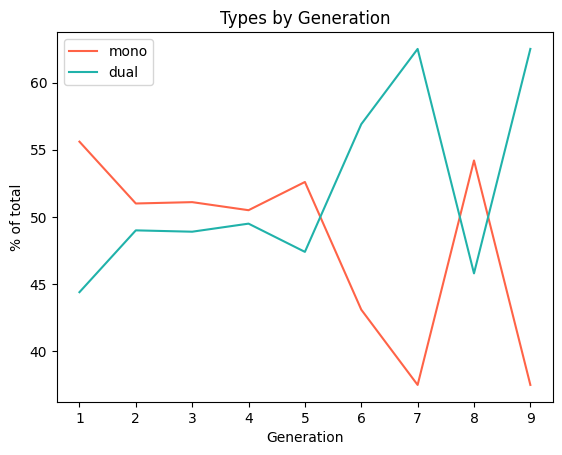

In [19]:
gen_percentages = []
for gen in gen_types:
    mono = gen['monotypes']
    dual = gen['dualtypes']
    total = mono + dual
    mono_percent = round(mono / total * 100, 1)
    dual_percent = round(dual / total * 100, 1)
    gen_percentages.append({
        'generation': gen['generation'],
        'mono': mono_percent,
        'dual': dual_percent
    })
percentages_df = pd.DataFrame.from_dict(gen_percentages)
percentages_df
gen_vals = percentages_df['generation'].to_list()
mono_vals = percentages_df['mono'].to_list()
dual_vals = percentages_df['dual'].to_list()

x = np.array(gen_vals)
plt.plot(x, mono_vals, 'tomato', label='mono')
plt.plot(x, dual_vals, 'lightseagreen', label='dual')

plt.xlabel('Generation')
plt.ylabel("% of total")
plt.legend()
plt.title('Types by Generation')

plt.show()

Text(0.5, 1.0, '# of Broken Links per Generation')

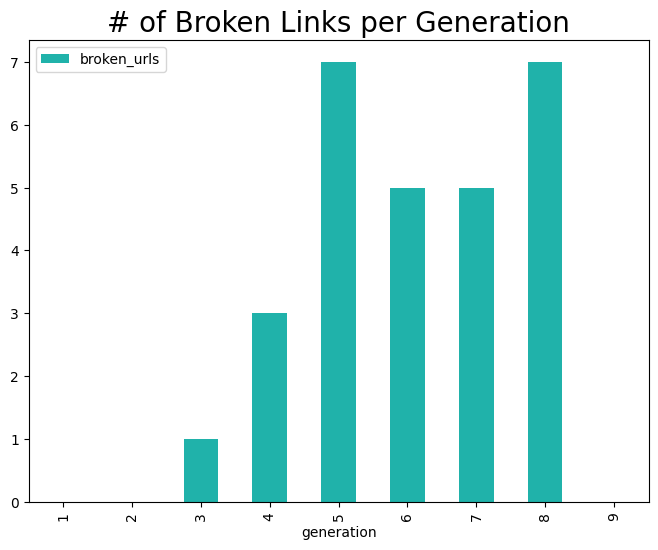

In [20]:
count_broken_df = all_pokemon_df.merge(broken_endpoints_df_cleaned, how="left", on="name")
count_broken_df.drop(columns=["id", "name", "type1", "type2"], inplace=True)

def count_broken(df, gen_num):
    return len(df[df['generation'] == gen_num].dropna())

broken_counts = []
for gen_num in range(1,10):
    broken_counts.append({
        'generation': gen_num,
        'broken_urls': count_broken(count_broken_df, gen_num)
    })
broken_ax = pd.DataFrame.from_dict(broken_counts).plot.bar(
    x='generation',
    figsize=(8,6),
    color='lightseagreen'
)

broken_ax.set_title('# of Broken Links per Generation', fontsize=20)

# Findings
- Gen 1, 3, and 5 had the most number of pokemon species
- Gen 1 had the highest percentage of mono-types at 55.6%
- Gen 7 & 9 both tied for the highest percentage of dual-types at 62.5%
- Gen 6, 7, 9 had the more dual-types than mono-types
- PokeApi contains 28 broken endpoints for pokemon names, listed in broken_endpoints.json. It will be a good idea to reach out to the maintainers to let them know about this so they can fix it.
- Gen 1, 2, and 9 were the only generations without any broken urls, the rest all had at least one. Gen 5 and 8 had the most with 7 broken urls each.